# Задание №2. Анализ данных о сердечно-сосудистых заболеваниях

В этом задании вы ответите на вопросы о наборе данных о сердечно-сосудистых заболеваниях. Загружать данные не нужно: они уже есть в репозитории. Есть некоторые Задачи, которые потребуют от вас написания кода.

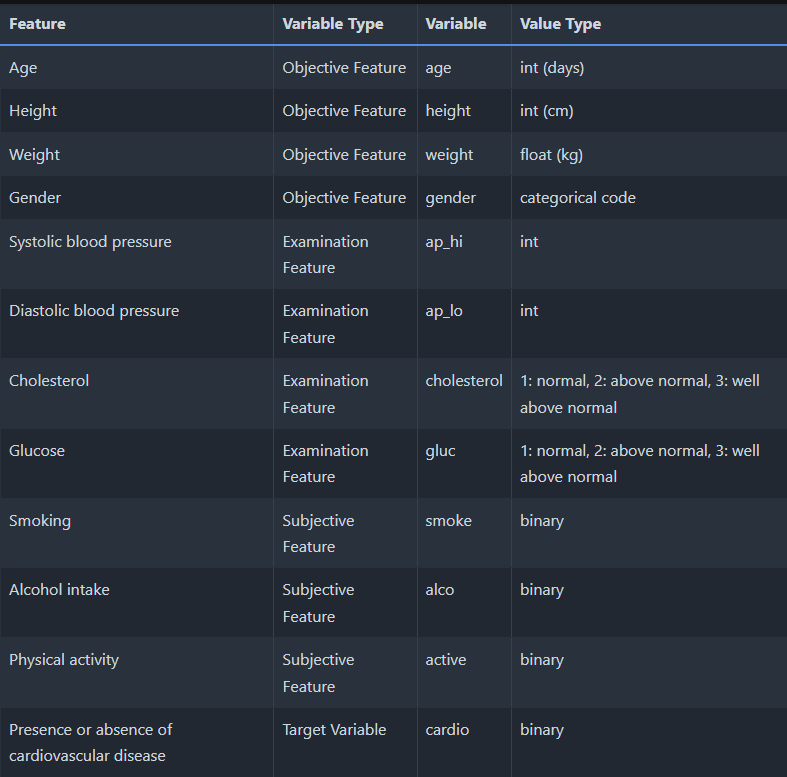

In [2]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1. Предварительный анализ. 

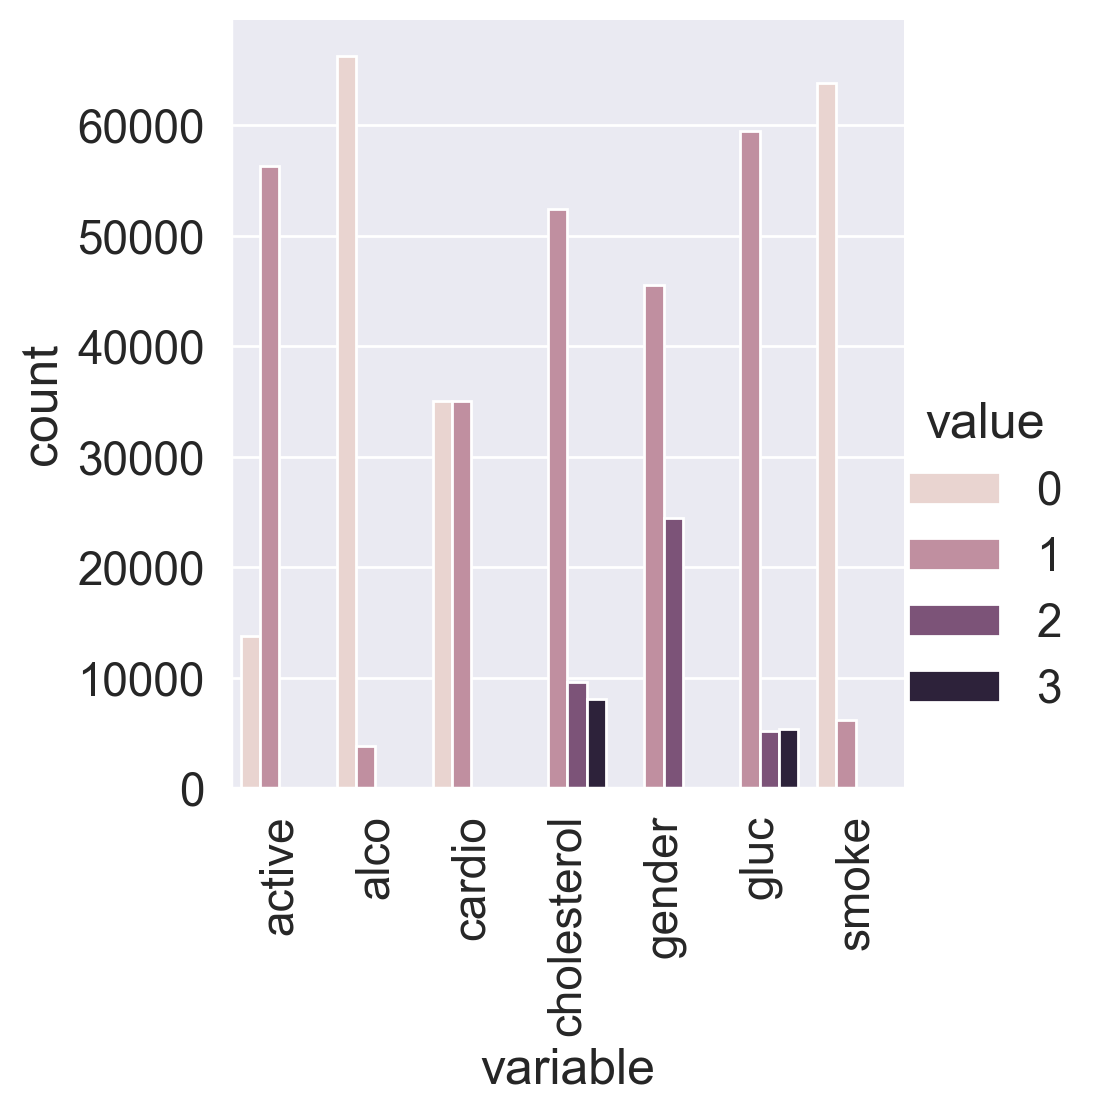

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

Можно заметить, что целевая категория cardio разделена равномерно. Большинство респонзентов занимаются физической активностью, не пьют, не курят. Холестирин и глюкоза у большинства в норме. Рассмотрим процентные соотношения:

In [6]:
print('Соотношение в категории физ.активность:',df['active'].value_counts(normalize=True))
print('Соотношение в категории алкоголь:',df['alco'].value_counts(normalize=True))
print('Соотношение в категории проблемы с сердцем:',df['cardio'].value_counts(normalize=True))


Соотношение в категории физ.активность: active
1    0.803729
0    0.196271
Name: proportion, dtype: float64
Соотношение в категории алкоголь: alco
0    0.946229
1    0.053771
Name: proportion, dtype: float64
Соотношение в категории проблемы с сердцем: cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


In [7]:
print('Соотношение в категории холестирин:',df['cholesterol'].value_counts(normalize=True))
print('Соотношение в категории пол:',df['gender'].value_counts(normalize=True))
print('Соотношение в категории глюкоза:',df['gluc'].value_counts(normalize=True))
print('Соотношение в категории курение:',df['smoke'].value_counts(normalize=True))

Соотношение в категории холестирин: cholesterol
1    0.748357
2    0.136414
3    0.115229
Name: proportion, dtype: float64
Соотношение в категории пол: gender
1    0.650429
2    0.349571
Name: proportion, dtype: float64
Соотношение в категории глюкоза: gluc
1    0.849700
3    0.076157
2    0.074143
Name: proportion, dtype: float64
Соотношение в категории курение: smoke
0    0.911871
1    0.088129
Name: proportion, dtype: float64


Рассмотрим те же данные, но разделив респонзентов на две группы. У которых есть проблемы и у которых их нет.

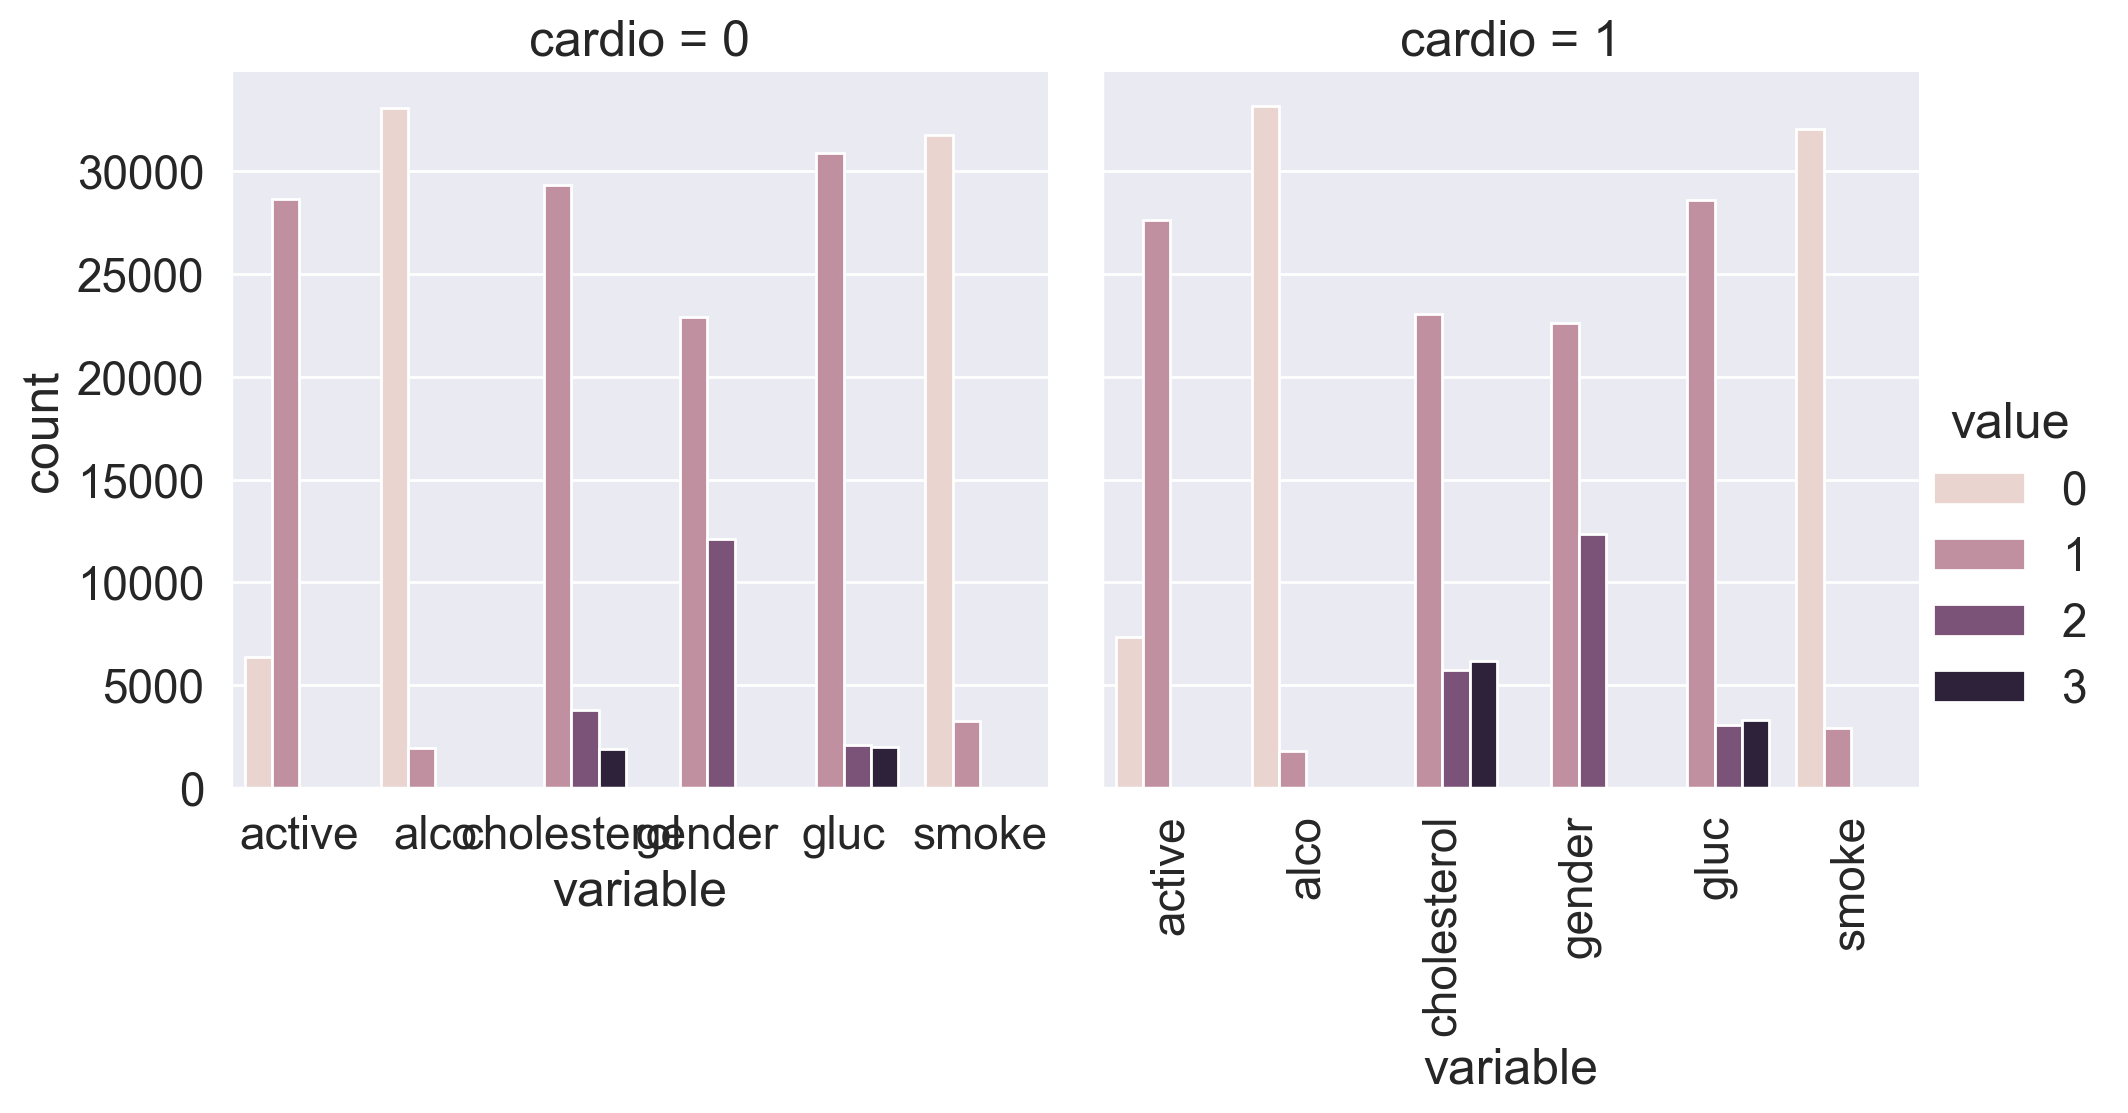

In [8]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)
sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
)
plt.xticks(rotation='vertical');

Заметна разница в категории глюкозы и холестирина. Может в этом решение задачи? 

Теперь давайте подсчитаем статистику уникальных значений признака:

In [9]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


В итоге у нас получается:

* 5 числовых характеристик (за исключением id);

* 7 категориальных признаков;

* Всего 70 000 записей.

## 1.2. Основные наблюдения

Вопрос 1.1. (1 балл). Сколько мужчин и женщин представлено в этом наборе данных? Значения признака gender не указаны (неясно, означает ли «1» женщину или мужчину) — выясните это, проанализировав рост и предположив, что мужчины в среднем выше.

In [10]:
print(df[df['gender']==1]['height'].mean())
print(df[df['gender']==2]['height'].mean())
print(df['gender'].value_counts())

161.35561168460356
169.94789538210054
gender
1    45530
2    24470
Name: count, dtype: int64


24470 мужчин и 45530 женщин

Вопрос 1.2. (1 балл). Кто чаще употребляет алкоголь — мужчины или женщины?

<Axes: xlabel='gender', ylabel='count'>

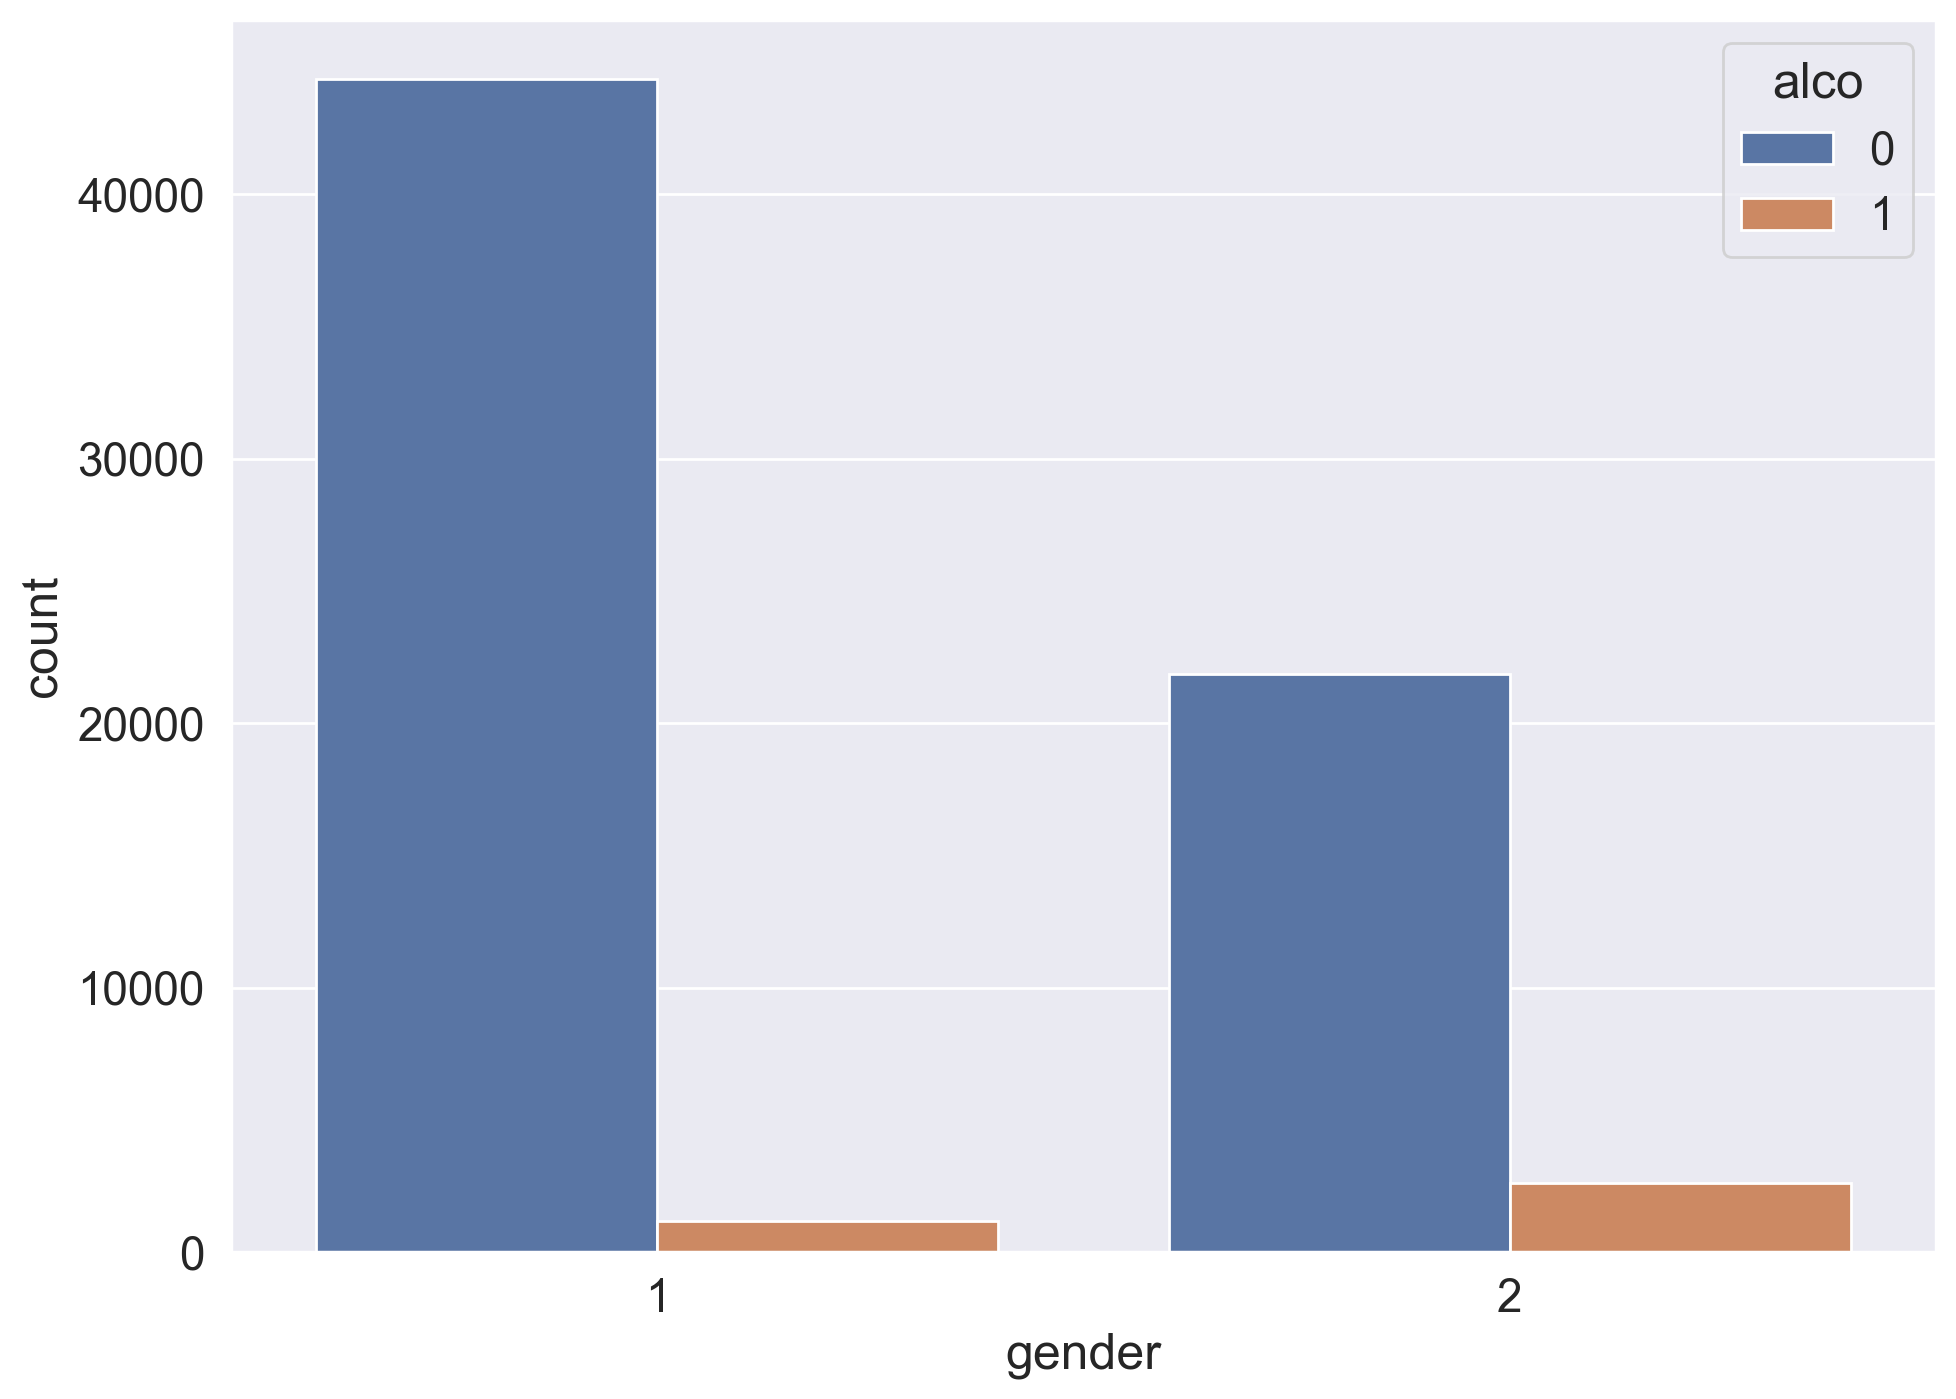

In [11]:
import seaborn as sns
sns.countplot(x="gender", hue="alco", data=df)

Вопрос 1.3. (1 балл). Какова разница в процентном соотношении курильщиков среди мужчин и женщин?

In [13]:
df.groupby('gender')['smoke'].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

Вопрос 1.4. (1 балл). Какова округлённая разница между медианными значениями возраста (в месяцах) для некурящих и курящих? Вам нужно будет определить единицы измерения признака age в этом наборе данных.

In [18]:
df.groupby('smoke')['age'].median()/365*12 # в месяцах

smoke
0    648.394521
1    628.767123
Name: age, dtype: float64

# 1.3 Карты рисков

На веб-сайте Европейского общества кардиологов представлена шкала SCORE. Она используется для расчёта риска смерти от сердечно-сосудистых заболеваний в ближайшие 10 лет. Вот она:

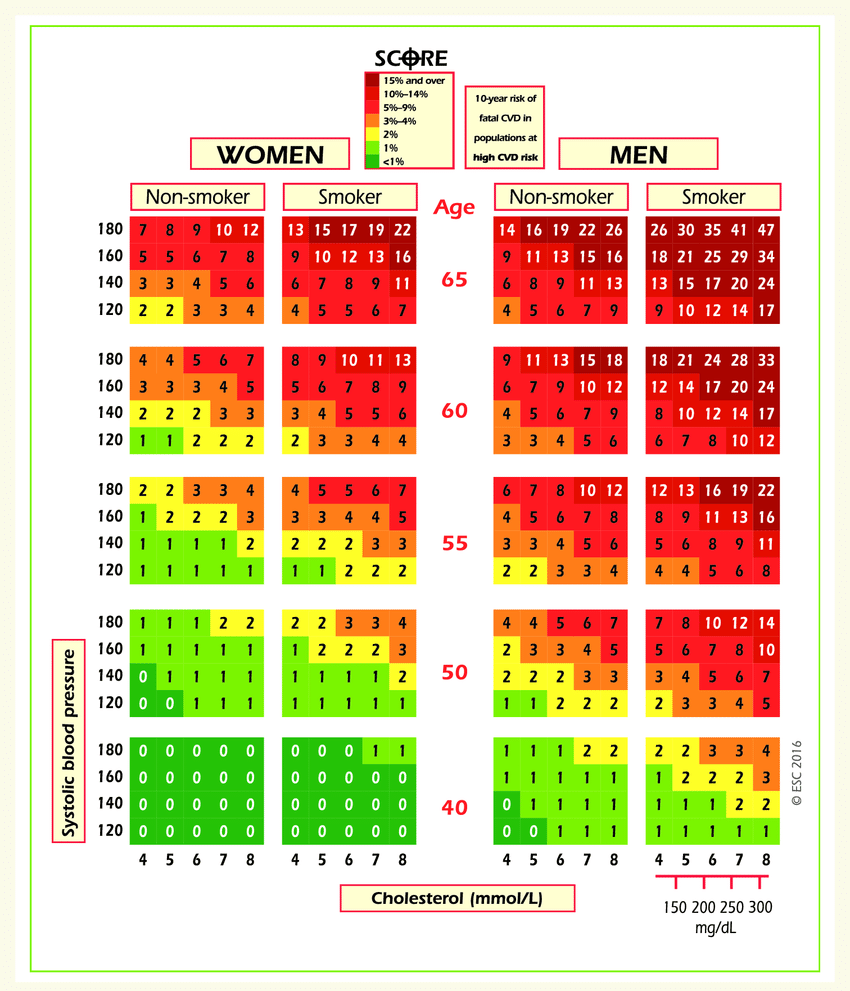

Давайте взглянем на верхний правый прямоугольник, в котором показано подмножество курящих мужчин в возрасте от 60 до 65 лет. (Это неочевидно, но значения на рисунке представляют собой верхнюю границу).

В левом нижнем углу прямоугольника мы видим значение 9, а в правом верхнем — 47. Это означает, что для людей этой возрастной группы, у которых систолическое давление ниже 120, риск сердечно-сосудистых заболеваний в 5 раз ниже, чем для тех, у кого давление находится в диапазоне [160, 180).

Давайте рассчитаем то же соотношение, но с нашими данными.

* Вычислите age_years признак — округлённый возраст в годах. Для этого задания выберите людей в возрасте от 60 до 64 лет включительно.

* Категории уровня холестерина на рисунке и в наших данных различаются. На рисунке значения cholesterol признака следующие: 4 ммоль/л 
 1,5–7 ммоль/л 
 2,8 ммоль/л 
 3

In [20]:
df['age_years'] = (df['age']/365).round().astype('int')

In [21]:
df['age_years'].max()

np.int64(65)

Самым пожилым людям в выборке 65 лет. Совпадение? Не думаю! Давайте выберем курящих мужчин в возрасте [60–64] лет.

In [22]:
smoke_old = df[(df['age_years']<65) & (df['age_years']>=60) & (df['smoke']==1) & (df['gender']==2)]

In [27]:
smoke_old[(smoke_old['cholesterol']==1) & (smoke_old['ap_hi']<120)]['cardio'].mean()

np.float64(0.2564102564102564)

Если уровень холестерина в этой возрастной группе составляет 1, а систолическое давление — ниже 120, то доля людей с сердечно-сосудистыми заболеваниями составляет 26%.

In [28]:
smoke_old[
    (smoke_old["cholesterol"] == 3)
    & (smoke_old["ap_hi"] >= 160)
    & (smoke_old["ap_hi"] < 180)
]["cardio"].mean()

np.float64(0.8636363636363636)

Если уровень холестерина в этой возрастной группе составляет 3, а систолическое давление в пределах 160-180, то доля людей с сердечно-сосудистыми заболеваниями составляет 86%.

В результате разница составляет примерно 3 раза. Не 5 раз, как показывает шкала SCORE, но, возможно, риск сердечно-сосудистых заболеваний по шкале SCORE нелинейно зависит от доли больных в данной возрастной группе.